# Project Proposal
- Michael Roper
- 4/2/2025
  

### Web Scraping Box Office Mojo

In [39]:
# Import necessary libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Define the base URL
base_url = "https://www.boxofficemojo.com/chart/top_lifetime_gross/?area=XWW"

# Initialize an empty list to store the data
all_movies_data = []

# Determine the number of pages (5)
num_pages = 5

# Loop through each page
for page in range(1, num_pages + 1):
    # Construct the URL for the current page
    url = f"{base_url}&offset={(page - 1) * 200}"  # Each page to display 200 movies

    print(f"Scraping page: {page}")

    try:
        # Send a GET request to the URL
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for HTTP errors

        # Parse the HTML content using BeautifulSoup
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find the table containing the movie data
        table = soup.find('table')

        if table:
            # Extract the table headers
            headers = [th.text.strip() for th in table.find_all('th')]

            # Find all the table rows (excluding the header row)
            rows = table.find_all('tr')[1:]

            # Iterate through each row and extract the data
            for row in rows:
                cells = row.find_all('td')
                if len(cells) == 4:
                    rank = cells[0].text.strip()
                    title = cells[1].find('a').text.strip() if cells[1].find('a') else cells[1].text.strip()
                    lifetime_gross = cells[2].text.strip()
                    year = cells[3].text.strip()

                    movie_data = {
                        "Rank": rank,
                        "Title": title,
                        "Lifetime Gross": lifetime_gross,
                        "Year": year
                    }
                    all_movies_data.append(movie_data)
                elif len(cells) > 0:
                    print(f"Warning: Row with unexpected number of cells: {len(cells)}")

        else:
            print("Error: Could not find the movie data table on the page.")

    except requests.exceptions.RequestException as e:
        print(f"Error fetching page {page}: {e}")
    except Exception as e:
        print(f"An error occurred while processing page {page}: {e}")

# Create a Pandas DataFrame from the collected data
df = pd.DataFrame(all_movies_data)

# Print the DataFrame
print("\nCollected Movie Data:")
print(df)

# Save the data to a CSV file
df.to_csv('box_office_mojo_top_worldwide.csv', index=False)

Scraping page: 1
Scraping page: 2
Scraping page: 3
Scraping page: 4
Scraping page: 5

Collected Movie Data:
      Rank                                       Title  Lifetime Gross  Year
0        1                                      Avatar  $2,923,710,708  2009
1        2                           Avengers: Endgame  $2,799,439,100  2019
2        3                    Avatar: The Way of Water  $2,320,250,281  2022
3        4                                     Titanic  $2,264,812,968  1997
4        5  Star Wars: Episode VII - The Force Awakens  $2,071,310,218  2015
..     ...                                         ...             ...   ...
995    996                                    Outbreak    $189,859,560  1995
996    997                             Under the Light    $189,404,720  2023
997    998               The White Storm 2: Drug Lords    $189,396,380  2019
998    999                                 The X Files    $189,176,423  1998
999  1,000                     Insidious: The

### Removing columns from downloaded dataset

In [35]:
# Load the CSV file into a pandas DataFrame
try:
    df = pd.read_csv('imdb_top_1000.csv')
except FileNotFoundError:
    print("Error: The file 'imdb_top_1000.csv' was not found. Make sure the file is in the same directory as your notebook or provide the correct path.")
    exit()

# Define the list of columns to keep
columns_to_keep = [ 'Series_Title', 'IMDB_Rating', 'Genre', 'Runtime', 'Certificate', 'Released_Year']

# Select only the desired columns
try:
    df_selected = df[columns_to_keep]
except KeyError as e:
    print(f"Error: One or more of the specified columns were not found in the CSV file: {e}")
    print(f"Available columns in the CSV: {df.columns.tolist()}")
    exit()

# Save the new DataFrame to a new CSV file
new_file_name = 'imdb_selected_columns.csv'
df_selected.to_csv(new_file_name, index=False)

print(f"Successfully created a new CSV file named '{new_file_name}' with the selected columns.")

Successfully created a new CSV file named 'imdb_selected_columns.csv' with the selected columns.


### Cleaning 

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Load IMDb data
imdb_df = pd.read_csv('imdb_selected_columns.csv')

# Load Box Office data
box_office_df = pd.read_csv('box_office_mojo_top_worldwide.csv', thousands=',')

# Clean the Lifetime Gross column - remove $ and commas, convert to float
box_office_df['Lifetime Gross'] = box_office_df['Lifetime Gross'].str.replace('[\$,]', '', regex=True).astype(float)

# Clean the Title column - remove extra quotes if any
box_office_df['Title'] = box_office_df['Title'].str.strip('"')

# Clean the Runtime column - extract just the numeric part
imdb_df['Runtime'] = imdb_df['Runtime'].str.extract('(\d+)').astype(float)

# Clean the Genre column - standardize format
imdb_df['Genre'] = imdb_df['Genre'].str.title()

# Clean the Series_Title column - remove extra quotes if any
imdb_df['Series_Title'] = imdb_df['Series_Title'].str.strip('"')

### Integrating

In [54]:
# Convert to integers (make sure there are no non-numeric values)
imdb_df['Released_Year'] = pd.to_numeric(imdb_df['Released_Year'], errors='coerce')
box_office_df['Year'] = pd.to_numeric(box_office_df['Year'], errors='coerce')

# Drop any rows with NA in year columns if needed
imdb_df = imdb_df.dropna(subset=['Released_Year'])
box_office_df = box_office_df.dropna(subset=['Year'])

# Convert to integers
imdb_df['Released_Year'] = imdb_df['Released_Year'].astype(int)
box_office_df['Year'] = box_office_df['Year'].astype(int)

# Now perform the merge
merged_df = pd.merge(
    imdb_df,
    box_office_df,
    left_on=['Series_Title', 'Released_Year'],
    right_on=['Title', 'Year'],
    how='left'
)

merged_df.to_csv('cleaned_movie_data.csv', index=False)

### Dropping Extra Variables, and Creating Dummy Variables

In [8]:
import pandas as pd

# Load the cleaned data
df = pd.read_csv('cleaned_movie_data.csv')

# Display initial columns to verify
print("Original columns:", df.columns.tolist())
print("\nFirst few rows:")
display(df.head())

# Clean the Genre column (remove extra spaces, standardize format)
df['Genre'] = df['Genre'].str.title().str.strip()

# Create dummy variables for genres (split by comma)
genre_dummies = df['Genre'].str.get_dummies(sep=', ')

# Drop the original Genre column and any duplicate title/year columns
columns_to_drop = ['Year', 'Title']  # These appear redundant with 'Title' and 'Year'
if 'Title' in df.columns and 'Series_Title' in df.columns:
    df = df.drop(columns=['Title'])
if 'Year' in df.columns and 'Released_Year' in df.columns:
    df = df.drop(columns=['Year'])

# Combine the original data with genre dummies
final_df = pd.concat([df, genre_dummies], axis=1)

# Save to new CSV
final_df.to_csv('movies_with_genre_dummies.csv', index=False)

# Display results
print("\nFinal columns:", final_df.columns.tolist())
print("\nSample rows with genre dummies:")
display(final_df.head())

Original columns: ['Series_Title', 'IMDB_Rating', 'Genre', 'Runtime', 'Certificate', 'Released_Year', 'Rank', 'Title', 'Lifetime Gross', 'Year']

First few rows:


,Series_Title,IMDB_Rating,Genre,Runtime,Certificate,Released_Year,Rank,Title,Lifetime Gross,Year
0,The Shawshank Redemption,9.3,Drama,142.0,A,1994,NaN,NaN,NaN,NaN
1,The Godfather,9.2,"Crime, Drama",175.0,A,1972,717.0,The Godfather,2.503422e+08,1972.0
2,The Dark Knight,9.0,"Action, Crime, Drama",152.0,UA,2008,56.0,The Dark Knight,1.009057e+09,2008.0
3,The Godfather: Part II,9.0,"Crime, Drama",202.0,A,1974,NaN,NaN,NaN,NaN
4,12 Angry Men,9.0,"Crime, Drama",96.0,U,1957,NaN,NaN,NaN,NaN



Final columns: ['Series_Title', 'IMDB_Rating', 'Genre', 'Runtime', 'Certificate', 'Released_Year', 'Rank', 'Lifetime Gross', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']

Sample rows with genre dummies:


,Series_Title,IMDB_Rating,Genre,Runtime,Certificate,Released_Year,Rank,Lifetime Gross,Action,Adventure,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,The Shawshank Redemption,9.3,Drama,142.0,A,1994,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Godfather,9.2,"Crime, Drama",175.0,A,1972,717.0,2.503422e+08,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Dark Knight,9.0,"Action, Crime, Drama",152.0,UA,2008,56.0,1.009057e+09,1,0,...,0,0,0,0,0,0,0,0,0,0
3,The Godfather: Part II,9.0,"Crime, Drama",202.0,A,1974,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12 Angry Men,9.0,"Crime, Drama",96.0,U,1957,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0


## Initial Analysis: IMDb Ratings vs. Box Office Success
### This notebook performs initial exploratory data analysis, hypothesis testing, and builds a simple machine learning model based on the project proposal.


In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import re # For cleaning 'Lifetime Gross'

# Configure plots
%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


## 1. Load Data

In [18]:
# Load the dataset
file_path = 'movies_with_genre_dummies.csv'
try:
    df = pd.read_csv(file_path)
    print("Data loaded successfully.")
    print(f"Dataset shape: {df.shape}")
    print("\nFirst 5 rows:")
    display(df.head())
    print("\nColumn names:")
    print(df.columns.tolist())
    print("\nData types:")
    print(df.info())
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    # Stop execution if file not found
    exit()
except Exception as e:
    print(f"An error occurred while loading the data: {e}")
    # Stop execution on other loading errors
    exit()


Data loaded successfully.
Dataset shape: (999, 29)

First 5 rows:


,Series_Title,IMDB_Rating,Genre,Runtime,Certificate,Released_Year,Rank,Lifetime Gross,Action,Adventure,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,The Shawshank Redemption,9.3,Drama,142.0,A,1994,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Godfather,9.2,"Crime, Drama",175.0,A,1972,717.0,2.503422e+08,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Dark Knight,9.0,"Action, Crime, Drama",152.0,UA,2008,56.0,1.009057e+09,1,0,...,0,0,0,0,0,0,0,0,0,0
3,The Godfather: Part II,9.0,"Crime, Drama",202.0,A,1974,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12 Angry Men,9.0,"Crime, Drama",96.0,U,1957,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0



Column names:
['Series_Title', 'IMDB_Rating', 'Genre', 'Runtime', 'Certificate', 'Released_Year', 'Rank', 'Lifetime Gross', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']

Data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Series_Title    999 non-null    object 
 1   IMDB_Rating     999 non-null    float64
 2   Genre           999 non-null    object 
 3   Runtime         999 non-null    float64
 4   Certificate     898 non-null    object 
 5   Released_Year   999 non-null    int64  
 6   Rank            173 non-null    float64
 7   Lifetime Gross  173 non-null    float64
 8   Action          999 non-null    int64  
 9   Adventure       999 non-null    in

## 2. Univariate Analysis

### IMDB Rating

Summary statistics for IMDB Rating:
count    999.000000
mean       7.949650
std        0.275407
min        7.600000
25%        7.700000
50%        7.900000
75%        8.100000
max        9.300000
Name: IMDB_Rating, dtype: float64


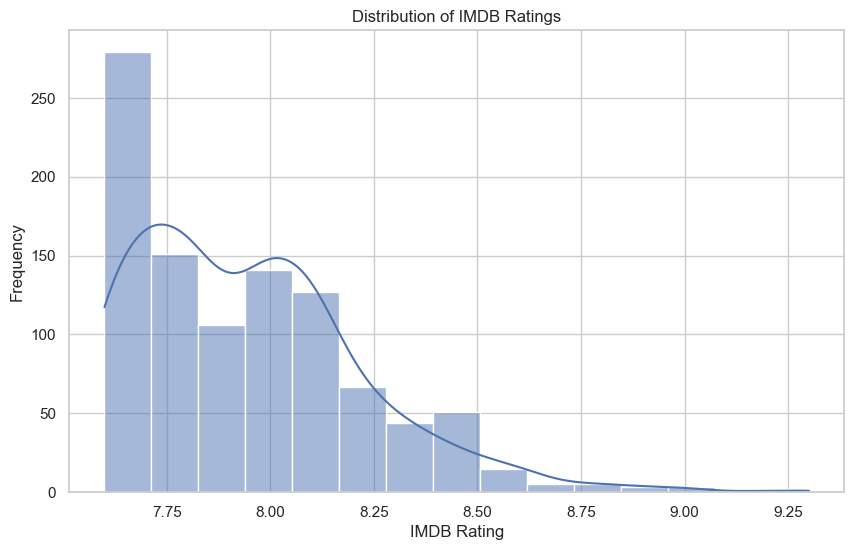

In [24]:
print("Summary statistics for IMDB Rating:")
print(df['IMDB_Rating'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df['IMDB_Rating'], kde=True, bins=15)
plt.title('Distribution of IMDB Ratings')
plt.xlabel('IMDB Rating')
plt.ylabel('Frequency')
plt.show()


### Lifetime Gross 


Summary statistics for Lifetime Gross:
count              173
mean       575,033,113
std        428,841,270
min        201,634,991
25%        306,889,114
50%        451,291,298
75%        723,719,539
max      2,923,710,708
Name: Lifetime Gross, dtype: object


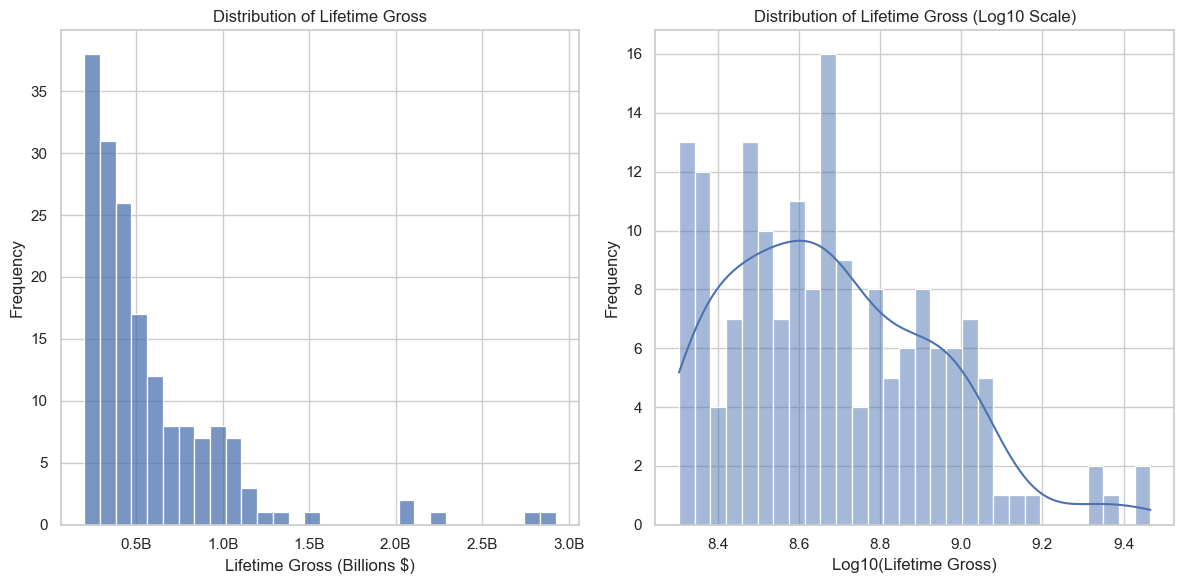

In [37]:
# Check if the column exists and has data
if 'Lifetime Gross' in df.columns and df['Lifetime Gross'].notna().any():
    print("\nSummary statistics for Lifetime Gross:")
    # Format large numbers for readability
    print(df['Lifetime Gross'].describe().apply(lambda x: f"{x:,.0f}"))

    plt.figure(figsize=(12, 6))

    # Histogram on original scale
    plt.subplot(1, 2, 1)
    sns.histplot(df['Lifetime Gross'].dropna(), kde=False, bins=30) # dropna() for safety
    plt.title('Distribution of Lifetime Gross')
    plt.xlabel('Lifetime Gross (Billions $)')
    plt.ylabel('Frequency')
    # Use FuncFormatter for cleaner axis labels
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x / 1e9:.1f}B'))


    # Histogram on log scale (better for skewed data)
    plt.subplot(1, 2, 2)
    # Use log10 for potentially easier interpretation
    # Add a small constant (e.g., 1) if there might be zero or negative values, though gross should be positive
    log_gross = np.log10(df['Lifetime Gross'].replace(0, 1).dropna()) # handle potential 0s and NaNs
    sns.histplot(log_gross, kde=True, bins=30)
    plt.title('Distribution of Lifetime Gross (Log10 Scale)')
    plt.xlabel('Log10(Lifetime Gross)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()
else:
    print("\nSkipping Lifetime Gross analysis as column is missing or empty after potential conversion issues.")


## 3. Bivariate Analysis

### IMDB Rating vs. Lifetime Gross


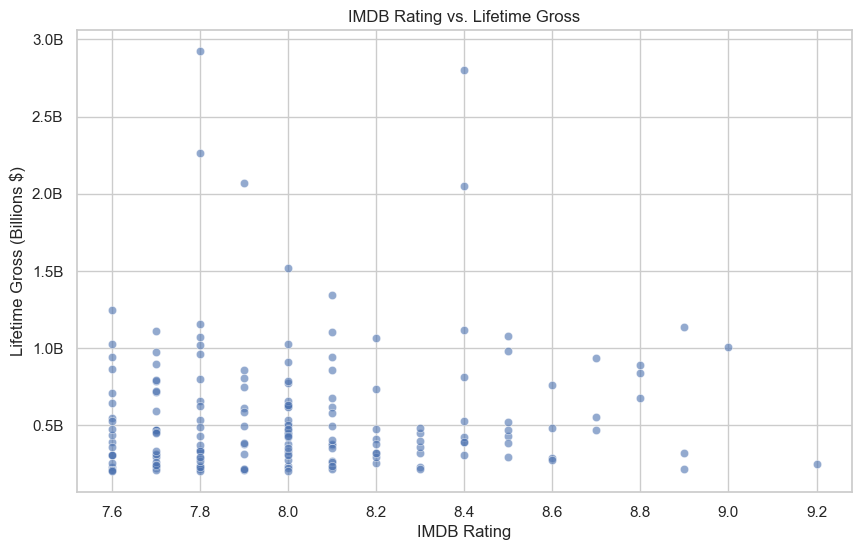


Pearson Correlation between IMDB Rating and Lifetime Gross: 0.069
Pearson p-value: 0.37

Spearman Correlation between IMDB Rating and Lifetime Gross: 0.088
Spearman p-value: 0.248

The Pearson correlation is not statistically significant (p >= 0.05).


In [42]:
if 'Lifetime Gross' in df.columns and df['Lifetime Gross'].notna().any() and \
   'IMDB_Rating' in df.columns and df['IMDB_Rating'].notna().any():
    
    plt.figure(figsize=(10, 6))
    # Drop NA values just for this plot to avoid errors
    plot_data = df[['IMDB_Rating', 'Lifetime Gross']].dropna()
    sns.scatterplot(data=plot_data, x='IMDB_Rating', y='Lifetime Gross', alpha=0.6)
    plt.title('IMDB Rating vs. Lifetime Gross')
    plt.xlabel('IMDB Rating')
    plt.ylabel('Lifetime Gross (Billions $)')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x / 1e9:.1f}B'))
    plt.show()

    # Calculate Correlation (using data points where both values are present)
    valid_data = df[['IMDB_Rating', 'Lifetime Gross']].dropna()
    if not valid_data.empty:
        correlation, p_value = stats.pearsonr(valid_data['IMDB_Rating'], valid_data['Lifetime Gross'])
        spearman_corr, spearman_p = stats.spearmanr(valid_data['IMDB_Rating'], valid_data['Lifetime Gross'])

        print(f"\nPearson Correlation between IMDB Rating and Lifetime Gross: {correlation:.3f}")
        print(f"Pearson p-value: {p_value:.3g}")
        print(f"\nSpearman Correlation between IMDB Rating and Lifetime Gross: {spearman_corr:.3f}")
        print(f"Spearman p-value: {spearman_p:.3g}")

        if p_value < 0.05:
            print("\nThe Pearson correlation is statistically significant (p < 0.05).")
        else:
            print("\nThe Pearson correlation is not statistically significant (p >= 0.05).")
    else:
        print("\nNot enough valid data points to calculate correlation.")

else:
     print("\nSkipping IMDB Rating vs Lifetime Gross analysis due to missing data.")



### Average Gross Earnings per Genre


Average Lifetime Gross per Genre:
Fantasy      $813,372,740
Adventure    $767,303,609
Action       $722,449,655
Sci-Fi       $716,415,307
Animation    $625,120,797
Music        $618,810,060
Family       $602,823,154
Comedy       $559,354,550
Romance      $528,458,237
Drama        $474,569,231
Thriller     $434,923,742
War          $416,625,829
Crime        $396,978,600
Western      $367,521,142
Mystery      $353,609,501
Biography    $325,248,428
History      $323,201,233
Horror       $320,437,841
Sport        $262,997,670
dtype: object


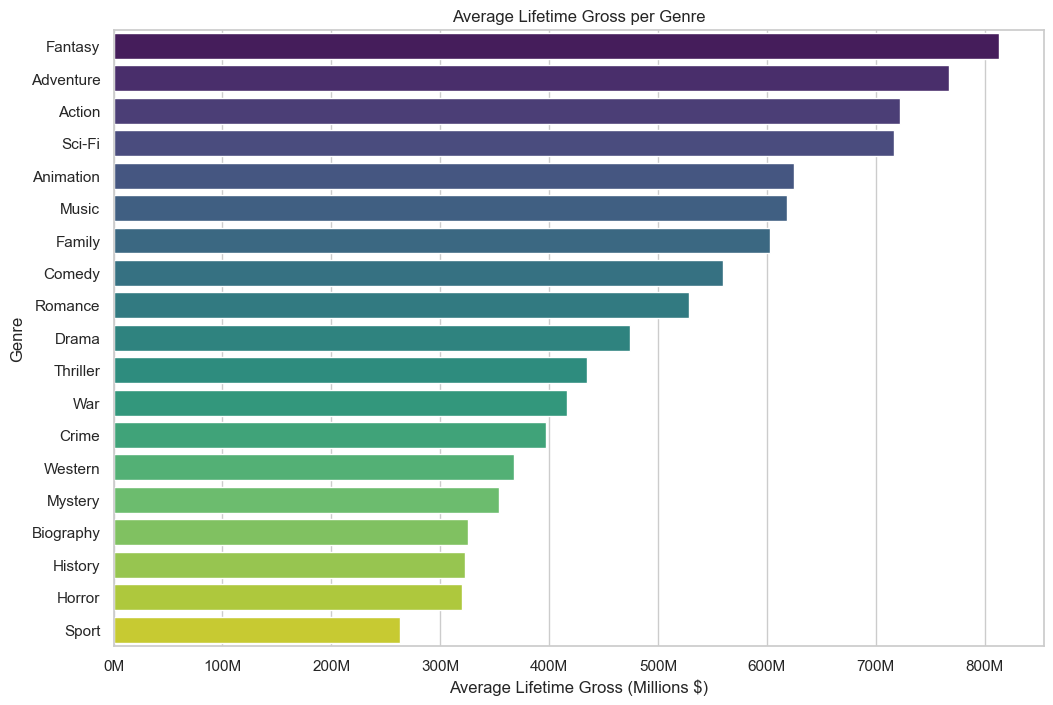

In [45]:
# Identify genre dummy columns
genre_cols = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']

# Verify genre columns exist
actual_genre_cols = [col for col in genre_cols if col in df.columns]
missing_genre_cols = [col for col in genre_cols if col not in df.columns]

if missing_genre_cols:
    print(f"Warning: The following expected genre columns were not found: {missing_genre_cols}")

if actual_genre_cols and 'Lifetime Gross' in df.columns and df['Lifetime Gross'].notna().any():
    genre_gross_avg = {}
    for genre in actual_genre_cols:
        # Ensure the dummy column is boolean or 0/1
        if pd.api.types.is_numeric_dtype(df[genre]) or pd.api.types.is_bool_dtype(df[genre]):
             # Calculate mean gross for movies belonging to this genre (where dummy == 1 or True)
             # Also ensure Lifetime Gross is not NaN for these rows
             valid_gross_for_genre = df.loc[(df[genre] == 1) | (df[genre] == True), 'Lifetime Gross'].dropna()
             if not valid_gross_for_genre.empty:
                avg_gross = valid_gross_for_genre.mean()
                genre_gross_avg[genre] = avg_gross
        else:
            print(f"Warning: Genre column '{genre}' is not numeric or boolean, skipping.")


    if genre_gross_avg: # Check if dictionary is not empty
        # Convert to Series for easy sorting and plotting
        genre_gross_series = pd.Series(genre_gross_avg).sort_values(ascending=False)

        print("\nAverage Lifetime Gross per Genre:")
        print(genre_gross_series.apply(lambda x: f"${x:,.0f}"))

        plt.figure(figsize=(12, 8))
        sns.barplot(x=genre_gross_series.values, y=genre_gross_series.index, palette="viridis")
        plt.title('Average Lifetime Gross per Genre')
        plt.xlabel('Average Lifetime Gross (Millions $)')
        plt.ylabel('Genre')
        plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x / 1e6:.0f}M'))
        plt.show()
    else:
        print("\nCould not calculate average gross per genre. Check genre columns and data.")

else:
     print("\nSkipping Average Gross per Genre analysis due to missing data or genre columns.")


## 4. Hypothesis Test

### **Hypothesis 1:** Higher ratings correlate with higher earnings.
### * **H₀ (Null):** There is no correlation between IMDb rating and lifetime gross earnings ($\rho = 0$).
### * **H₁ (Alternative):** There is a positive correlation between IMDb rating and lifetime gross earnings ($\rho > 0$).

### We will use the correlation coefficients calculated earlier. Spearman's rank correlation is often preferred for potentially non-linear relationships or non-normally distributed data.


In [52]:
if 'Lifetime Gross' in df.columns and df['Lifetime Gross'].notna().any() and \
   'IMDB_Rating' in df.columns and df['IMDB_Rating'].notna().any():
    # Re-calculate Spearman using valid data points
    valid_data = df[['IMDB_Rating', 'Lifetime Gross']].dropna()

    if not valid_data.empty and len(valid_data) > 1: # Need at least 2 points for correlation
        spearman_corr, spearman_p = stats.spearmanr(valid_data['IMDB_Rating'], valid_data['Lifetime Gross'])

        print(f"\n--- Hypothesis Test: Rating vs. Earnings ---")
        print(f"Spearman Correlation Coefficient (rho): {spearman_corr:.3f}")
        # For a one-tailed test (rho > 0), divide the two-tailed p-value by 2
        one_tailed_p_value = spearman_p / 2
        print(f"One-tailed p-value: {one_tailed_p_value:.3g}")

        alpha = 0.05
        print(f"Significance Level (alpha): {alpha}")

        if spearman_corr > 0 and one_tailed_p_value < alpha:
            print(f"\nResult: Reject the null hypothesis (H₀).")
            print("There is a statistically significant positive correlation between IMDB Rating and Lifetime Gross.")
        elif spearman_corr <= 0 and one_tailed_p_value < alpha :
             print(f"\nResult: Reject the null hypothesis (H₀).")
             print("There is a statistically significant *non-positive* correlation (rho <= 0). This contradicts H1.")
        else: # p_value >= alpha or correlation is not positive when testing for positive corr
            print(f"\nResult: Fail to reject the null hypothesis (H₀).")
            print("There is not enough evidence to conclude a significant positive correlation at the chosen alpha level.")
    else:
        print("\nSkipping Hypothesis Test - not enough valid data points.")
else:
    print("\nSkipping Hypothesis Test due to missing data.")


--- Hypothesis Test: Rating vs. Earnings ---
Spearman Correlation Coefficient (rho): 0.088
One-tailed p-value: 0.124
Significance Level (alpha): 0.05

Result: Fail to reject the null hypothesis (H₀).
There is not enough evidence to conclude a significant positive correlation at the chosen alpha level.


## 5. Machine Learning: Simple Linear Regression

### Predicting `Lifetime Gross` based on `IMDB_Rating`.


Training set size: 121
Testing set size: 52

--- Linear Regression Results ---
Coefficient (Slope for IMDB_Rating): 29,102,038.91
Intercept: 309,851,857.46

Training R-squared: 0.001
Training RMSE: $393,706,959
Testing R-squared: -0.041
Testing RMSE: $499,367,712

Interpretation: For each 1-point increase in IMDB Rating, the model predicts an increase of approximately $29,102,039 in Lifetime Gross, holding other factors constant.
However, the R-squared value (-0.041 on test set) indicates that IMDB Rating alone explains only about -4.1% of the variance in Lifetime Gross in this simple model.


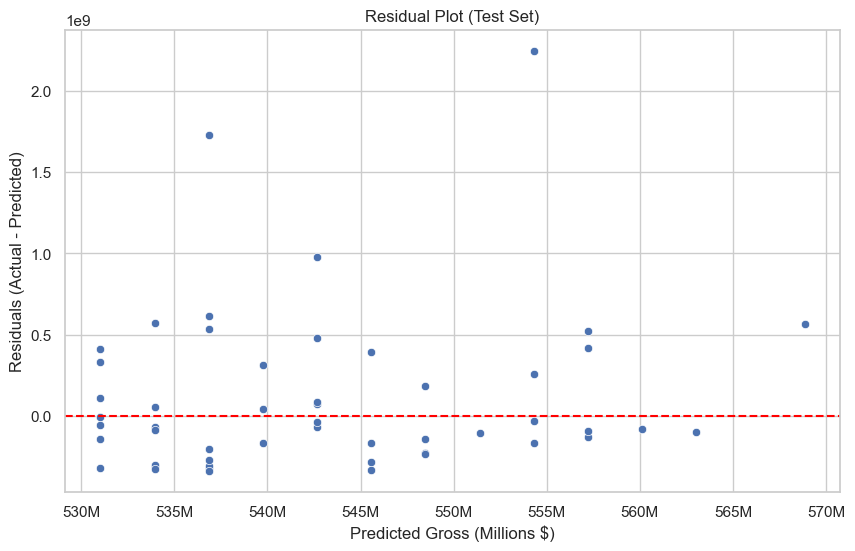

In [60]:
if 'Lifetime Gross' in df.columns and df['Lifetime Gross'].notna().any() and \
   'IMDB_Rating' in df.columns and df['IMDB_Rating'].notna().any():
   
    # Prepare data: Drop rows with missing values in target or feature
    regression_data = df[['IMDB_Rating', 'Lifetime Gross']].dropna()

    if regression_data.empty or len(regression_data) < 2: # Need at least 2 points for regression
        print("\nCannot perform regression: Not enough valid data points after dropping NaNs.")
    else:
        X = regression_data[['IMDB_Rating']] # Feature(s)
        y = regression_data['Lifetime Gross'] # Target

        # Split data into training and testing sets
        # Ensure enough data for split
        if len(regression_data) > 3:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            print(f"\nTraining set size: {X_train.shape[0]}")
            print(f"Testing set size: {X_test.shape[0]}")
        else:
            print("\nWarning: Dataset too small for train/test split. Using all data for training.")
            X_train, X_test, y_train, y_test = X, X, y, y # Use all data if too small

        # Initialize and train the model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Make predictions
        y_pred_train = model.predict(X_train)
        if not X_test.empty:
            y_pred_test = model.predict(X_test)
        else:
             y_pred_test = np.array([]) # Empty prediction if test set is empty


        # Evaluate the model
        train_r2 = r2_score(y_train, y_pred_train)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        
        print(f"\n--- Linear Regression Results ---")
        print(f"Coefficient (Slope for IMDB_Rating): {model.coef_[0]:,.2f}")
        print(f"Intercept: {model.intercept_:,.2f}")
        print(f"\nTraining R-squared: {train_r2:.3f}")
        print(f"Training RMSE: ${train_rmse:,.0f}")
        
        if not X_test.empty and len(y_test) > 0:
            test_r2 = r2_score(y_test, y_pred_test)
            test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
            print(f"Testing R-squared: {test_r2:.3f}")
            print(f"Testing RMSE: ${test_rmse:,.0f}")
            
            # Interpretation Aid
            print(f"\nInterpretation: For each 1-point increase in IMDB Rating, the model predicts an increase of approximately ${model.coef_[0]:,.0f} in Lifetime Gross, holding other factors constant.")
            print(f"However, the R-squared value ({test_r2:.3f} on test set) indicates that IMDB Rating alone explains only about {test_r2*100:.1f}% of the variance in Lifetime Gross in this simple model.")

            # Optional: Plot residuals
            plt.figure(figsize=(10, 6))
            residuals = y_test - y_pred_test
            sns.scatterplot(x=y_pred_test, y=residuals)
            plt.axhline(0, color='red', linestyle='--')
            plt.xlabel('Predicted Gross (Millions $)')
            plt.ylabel('Residuals (Actual - Predicted)')
            plt.title('Residual Plot (Test Set)')
            plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x / 1e6:.0f}M'))
            plt.show()
        else:
            print("\nSkipping test set evaluation and residual plot due to lack of test data.")


else:
    print("\nSkipping Simple Linear Regression due to missing data for 'Lifetime Gross' or 'IMDB_Rating'.")
